# Multi Stage Prediction 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [2]:
# Load Data

daily_data = pd.read_csv("daily_merged_data.csv")
monthly_data = pd.read_csv("merged_monthyl_data.csv")
yearly_data = pd.read_csv("merged_Yearly_data,csv")


In [3]:
# Convert datetime columns
daily_data["date"] = pd.to_datetime(daily_data["date"])

daily_data.set_index("date", inplace=True)

In [4]:
# Ensure numerical columns are correctly formatted
yearly_data["Population"] = yearly_data["Population"].str.replace(',', '').astype(float)

In [5]:
# Feature Engineering Function
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    
    # Print feature importances
    print("Feature Importances (Descending Order):")
    print(feature_importances)
    
    return feature_importances

## Stage 1: Yearly Forecasting

In [6]:
# One-Hot Encode PriceComponents
yearly_data = pd.get_dummies(yearly_data, columns=["PriceComponents"], drop_first=True)

In [7]:
# Ensure all rows are printed
pd.set_option('display.max_rows', None)

In [8]:
# Select Features and Target
yearly_features = yearly_data.drop(columns=["loadConsumption"])
yearly_target = "loadConsumption"
X_yearly = yearly_features
y_yearly = yearly_data[yearly_target]

In [9]:
# Compute feature importance
yearly_feature_importance = feature_importance_rfa(X_yearly, y_yearly)

# Select the top 5 features
selected_yearly_features = yearly_feature_importance.index[:5]
X_yearly = X_yearly[selected_yearly_features]

Feature Importances (Descending Order):
OffshoreWindEnergy (MWh)                                    1.141228e-01
Total Including Non-Renewable (MWh)                         8.399503e-02
Hydropower (MWh)                                            7.700621e-02
TotalGeothermal&GroundEnergy (MWh)                          6.285372e-02
TotalBiomass (MWh)                                          5.847204e-02
TotalSolarEnergy (MWh)                                      5.759465e-02
Half_Year                                                   5.206606e-02
TotalRes(incl.Stat.Transfer) (MWh)                          5.044067e-02
AmbientAirHeat (MWh)                                        4.544085e-02
TotalRes(excl.Stat.Transfer) (MWh)                          4.264283e-02
Population                                                  4.208972e-02
GeothermalHeat (MWh)                                        3.476135e-02
SolarPower (MWh)                                            3.340082e-02
Totaal wind

In [10]:
# Split Data
X_train_yearly, X_test_yearly, y_train_yearly, y_test_yearly = train_test_split(
    X_yearly, y_yearly, test_size=0.2, random_state=42
)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_yearly)
X_test_scaled = scaler.transform(X_test_yearly)

In [11]:
# Train Model
model_yearly = RandomForestRegressor(n_estimators=100, random_state=42)
model_yearly.fit(X_train_scaled, y_train_yearly)
y_pred_yearly = model_yearly.predict(X_test_scaled)

In [12]:
# Store yearly predictions in monthly dataset
monthly_data["Predicted_Yearly_Load"] = np.repeat(
    model_yearly.predict(scaler.transform(X_yearly)),
    len(monthly_data) // len(yearly_data)
)[:len(monthly_data)]

In [13]:
# Evaluate Model
print("Yearly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_yearly, y_pred_yearly)}, "
      f"MSE: {mean_squared_error(y_test_yearly, y_pred_yearly)}, "
      f"R^2: {r2_score(y_test_yearly, y_pred_yearly)}, "
      f"MAPE: {np.mean(np.abs((y_test_yearly - y_pred_yearly) / y_test_yearly)) * 100}")

Yearly Model Performance:
MAE: 92145.41036500037, MSE: 11152118845.504124, R^2: 0.9992810399015079, MAPE: 0.08169781956624085


In [14]:
monthly_data.isna().sum()

Year                                                      0
Month                                                     0
Gross production (MWh)                                    0
Net production/Net production, total (MWh)                0
Net production/Nuclear energy (MWh)                       3
Net production/Fuels/Fuels, total (MWh)                   0
Net production/Fuels/Coal (MWh)                           0
Net production/Fuels/Petroleum products (MWh)             0
Net production/Fuels/Natural gas (MWh)                    0
Net production/Fuels/Biomass (MWh)                        0
Net production/Fuels/Other fuels (non-renewable) (MWh)    0
Net production/Hydro power (MWh)                          0
Net production/Wind energy/Wind energy, total (MWh)       0
Net production/Wind energy/Wind energy on shore (MWh)     0
Net production/Wind energy/Wind energy off shore (MWh)    0
Net production/Solar photovoltaic (MWh)                   0
Net production/Other sources (MWh)      

In [15]:
monthly_data.fillna(method="ffill", inplace=True)

C:\Users\mahmo\AppData\Local\Temp\ipykernel_16060\1658306591.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data.fillna(method="ffill", inplace=True)


In [16]:
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Feature Engineering
monthly_features = monthly_data.drop(columns=["loadConsumption"])
monthly_target = "loadConsumption"
X_monthly = monthly_features
y_monthly = monthly_data[monthly_target]

# Compute Feature Importance
def feature_importance_rfa(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    return feature_importances

monthly_feature_importance = feature_importance_rfa(X_monthly, y_monthly)
selected_monthly_features = list(monthly_feature_importance.index[:8]) + ["Predicted_Yearly_Load"]
X_monthly = X_monthly[selected_monthly_features]

# Split Data
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(
    X_monthly, y_monthly, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled_monthly = scaler.fit_transform(X_train_monthly)
X_test_scaled_monthly = scaler.transform(X_test_monthly)

### **1️⃣ Random Forest Model**
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_monthly, y_train_monthly)
y_pred_rf = rf_model.predict(X_test_scaled_monthly)

### **2️⃣ Linear Regression Model**
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_monthly, y_train_monthly)
y_pred_lr = lr_model.predict(X_test_scaled_monthly)

### **3️⃣ LSTM Model**
X_train_lstm = X_train_scaled_monthly.reshape((X_train_scaled_monthly.shape[0], 1, X_train_scaled_monthly.shape[1]))
X_test_lstm = X_test_scaled_monthly.reshape((X_test_scaled_monthly.shape[0], 1, X_test_scaled_monthly.shape[1]))

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled_monthly.shape[1])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_monthly, epochs=50, batch_size=16, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

### **4️⃣ SARIMAX Model**
sarima_model = SARIMAX(y_train_monthly, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit(disp=False)
y_pred_sarima = sarima_results.predict(start=len(y_train_monthly), end=len(y_train_monthly) + len(y_test_monthly) - 1)

# Store Monthly Predictions in Daily Dataset
#num_days_per_month = len(daily_data) // len(monthly_data)

#predictions_rf = np.repeat(rf_model.predict(scaler.transform(X_monthly)), num_days_per_month)
#predictions_lr = np.repeat(lr_model.predict(scaler.transform(X_monthly)), num_days_per_month)
#predictions_lstm = np.repeat(lstm_model.predict(X_train_lstm).flatten(), num_days_per_month)
#predictions_sarima = np.repeat(sarima_results.predict(start=0, end=len(monthly_data) - 1), num_days_per_month)

# Handle potential size mismatch
def match_length(predictions, target_length):
    if len(predictions) < target_length:
        return np.append(predictions, [predictions[-1]] * (target_length - len(predictions)))
    return predictions[:target_length]

#daily_data["Predicted_Monthly_Load_RF"] = match_length(predictions_rf, len(daily_data))
#daily_data["Predicted_Monthly_Load_LR"] = match_length(predictions_lr, len(daily_data))
#daily_data["Predicted_Monthly_Load_LSTM"] = match_length(predictions_lstm, len(daily_data))
#daily_data["Predicted_Monthly_Load_SARIMA"] = match_length(predictions_sarima, len(daily_data))

# Save Updated Daily Data
#daily_data.to_csv("/mnt/data/daily_with_monthly_predictions.csv")

# Model Performance Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Model Performance:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}, MSE: {mean_squared_error(y_true, y_pred):.4f}, R^2: {r2_score(y_true, y_pred):.4f}, MAPE: {np.mean(np.abs((y_true - y_pred) / y_true)) * 100:.4f}%\n")

evaluate_model("Random Forest", y_test_monthly, y_pred_rf)
evaluate_model("Linear Regression", y_test_monthly, y_pred_lr)
evaluate_model("LSTM", y_test_monthly, y_pred_lstm)
evaluate_model("SARIMAX", y_test_monthly, y_pred_sarima)

print("✅ All models trained and predictions saved in daily dataset!")


1/1 [==============================] - 0s 374ms/step


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Random Forest Model Performance:
MAE: 411277.6330, MSE: 958425341188.9326, R^2: -0.2325, MAPE: 5.6576%

Linear Regression Model Performance:
MAE: 346068.6811, MSE: 921410810486.8705, R^2: -0.1849, MAPE: 4.9244%

LSTM Model Performance:
MAE: 8938969.3624, MSE: 80682831716846.4531, R^2: -102.7540, MAPE: 99.9964%

SARIMAX Model Performance:
MAE: 785564.1183, MSE: 1217306469693.7051, R^2: -0.5654, MAPE: 5.4074%

✅ All models trained and predictions saved in daily dataset!


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
## Stage 2: Monthly Breakdown
monthly_features = monthly_data.drop(columns=["loadConsumption"])
monthly_target = "loadConsumption"
X_monthly = monthly_features
y_monthly = monthly_data[monthly_target]

# Compute feature importance
monthly_feature_importance = feature_importance_rfa(X_monthly, y_monthly)
selected_monthly_features = list(monthly_feature_importance.index[:5]) + ["Predicted_Yearly_Load"]
X_monthly = X_monthly[selected_monthly_features]

# Train Monthly Model
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=0.2, random_state=42)
X_train_scaled_monthly = scaler.fit_transform(X_train_monthly)
X_test_scaled_monthly = scaler.transform(X_test_monthly)

model_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
model_monthly.fit(X_train_scaled_monthly, y_train_monthly)
y_pred_monthly = model_monthly.predict(X_test_scaled_monthly)

# Store monthly predictions in daily dataset
# Expand monthly predictions to match daily data size
num_days_per_month = len(daily_data) // len(monthly_data)
predicted_monthly_load = np.repeat(model_monthly.predict(scaler.transform(X_monthly)), num_days_per_month)

# Handle potential size mismatch
if len(predicted_monthly_load) < len(daily_data):
    predicted_monthly_load = np.append(predicted_monthly_load, predicted_monthly_load[-1] * np.ones(len(daily_data) - len(predicted_monthly_load)))

daily_data["Predicted_Monthly_Load"] = predicted_monthly_load[:len(daily_data)]


# Evaluate
print("Monthly Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_monthly, y_pred_monthly)}, MSE: {mean_squared_error(y_test_monthly, y_pred_monthly)}, R^2: {r2_score(y_test_monthly, y_pred_monthly)}, MAPE: {np.mean(np.abs((y_test_monthly - y_pred_monthly) / y_test_monthly)) * 100}")






Monthly Model Performance:
MAE: 401581.31658499903, MSE: 943997766757.2949, R^2: -0.21393288274205857, MAPE: 5.544667157382954


In [18]:
daily_data = pd.get_dummies(daily_data, columns=["day_of_week"], drop_first=True)

In [19]:
## Stage 3: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 7295.296931564876, MSE: 124473796.30478586, R^2: 0.8805589150029228, MAPE: 2.4826842931748185


In [20]:
## Stage 3: Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5])

# Train Daily Model
X_train_daily, X_test_daily, y_train_daily, y_test_daily = train_test_split(X_daily, y_daily, test_size=0.2, random_state=42)
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_test_scaled_daily = scaler.transform(X_test_daily)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_pred_daily = model_daily.predict(X_test_scaled_daily)

# Evaluate
print("Daily Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_daily, y_pred_daily)}, MSE: {mean_squared_error(y_test_daily, y_pred_daily)}, R^2: {r2_score(y_test_daily, y_pred_daily)}, MAPE: {np.mean(np.abs((y_test_daily - y_pred_daily) / y_test_daily)) * 100}")

Daily Model Performance:
MAE: 6130.463397938932, MSE: 85414718.41493973, R^2: 0.9180387604052856, MAPE: 2.0941992441796877


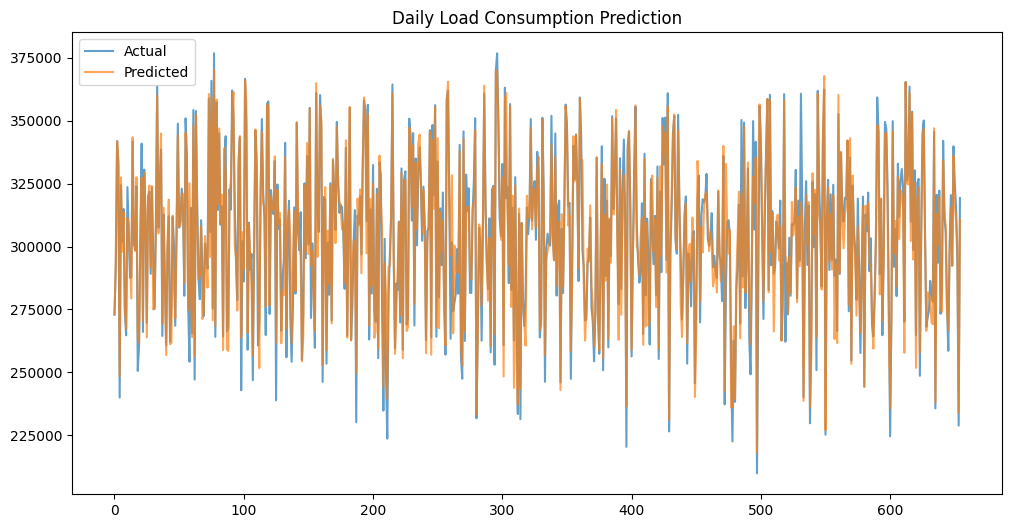

In [21]:
# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_daily.values, label="Actual", alpha=0.7)
plt.plot(y_pred_daily, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction")
plt.show()


In [22]:
## Stage 3: Future Daily Forecasting
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define prediction horizon (180-365 days into the future)
prediction_horizon = 180  # Change to 180 if needed
X_train_daily = X_daily.iloc[:-prediction_horizon]
y_train_daily = y_daily.iloc[:-prediction_horizon]
X_future = X_daily.iloc[-prediction_horizon:]

# Train Daily Model
scaler = StandardScaler()
X_train_scaled_daily = scaler.fit_transform(X_train_daily)
X_future_scaled = scaler.transform(X_future)

model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
model_daily.fit(X_train_scaled_daily, y_train_daily)
y_future_pred = model_daily.predict(X_future_scaled)


Future Daily Model Performance:
Predictions for the next 180 days generated.


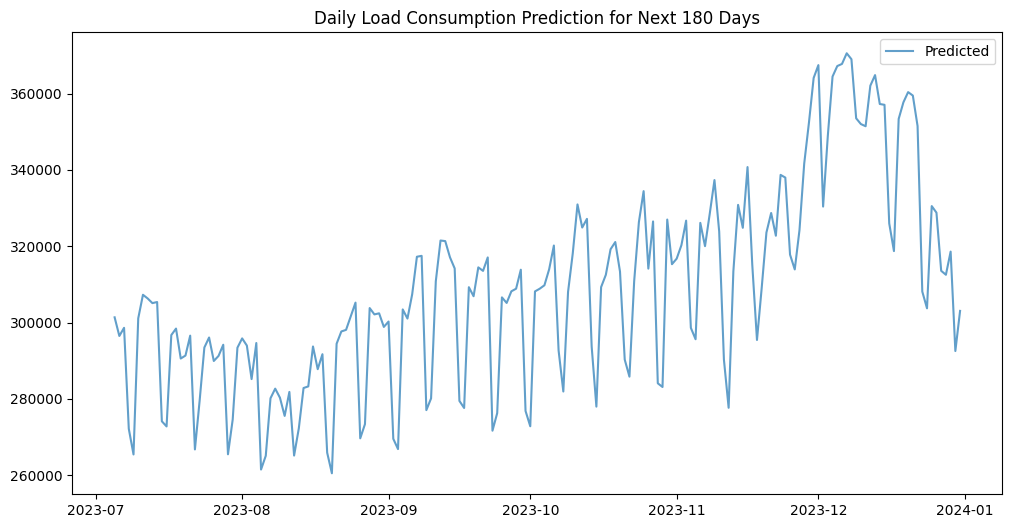

In [23]:
# Evaluate
print("Future Daily Model Performance:")
print(f"Predictions for the next {prediction_horizon} days generated.")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_daily.index[-prediction_horizon:], y_future_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title(f"Daily Load Consumption Prediction for Next {prediction_horizon} Days")
plt.show()


2019 Model Performance:
MAE: 8233.791856164384, MSE: 123586199.39033237, R^2: 0.859541523493988, MAPE: 2.7089747971563294
2023 Model Performance:
MAE: 10689.602884315113, MSE: 197597043.25474784, R^2: 0.7563755204599163, MAPE: 3.542191957376147


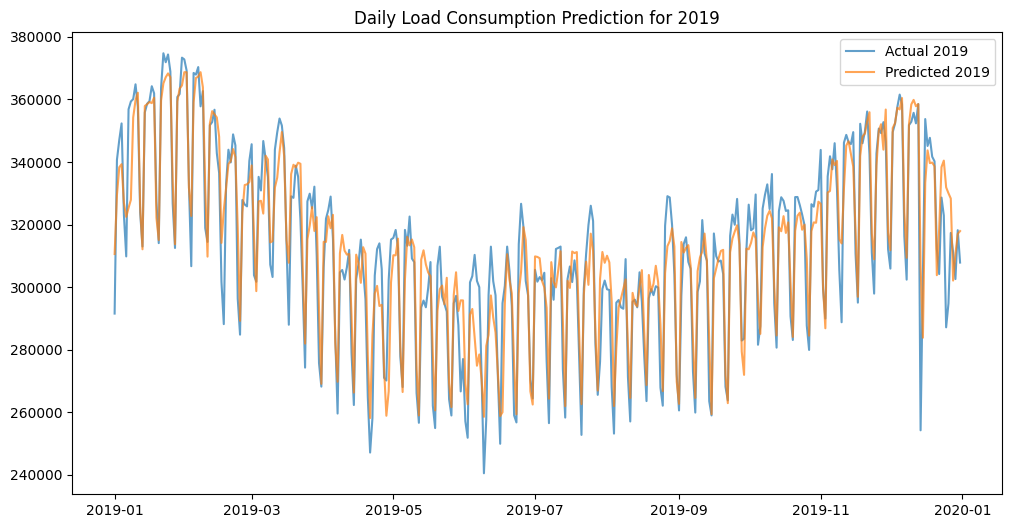

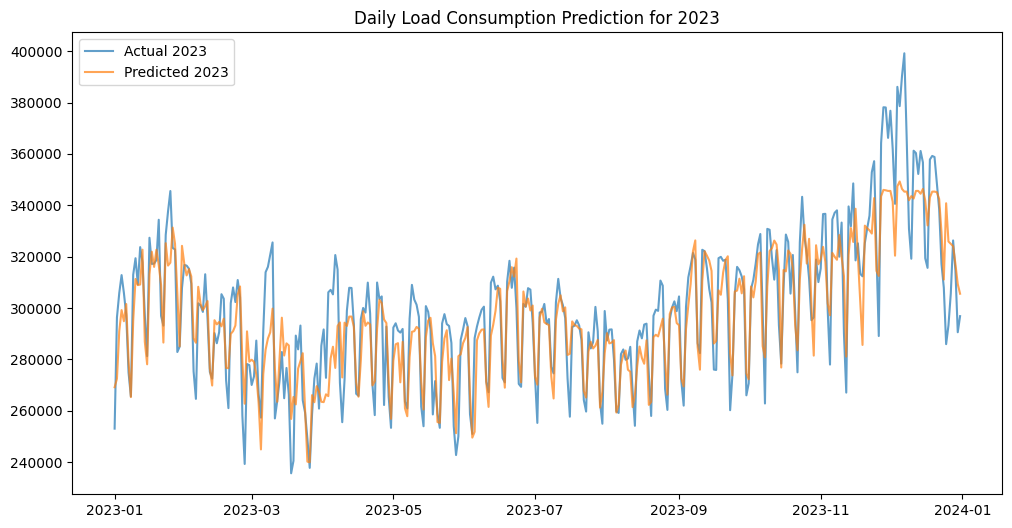

In [24]:
## Stage 3: Testing Performance on 2019 and 2023
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define 2019 and 2023 data
X_train_2019 = X_daily.loc["2018-01-01":"2018-12-31"]
y_train_2019 = y_daily.loc["2018-01-01":"2018-12-31"]
X_test_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_2019 = y_daily.loc["2019-01-01":"2019-12-31"]

X_train_2022 = X_daily.loc["2021-01-01":"2021-12-31"]
y_train_2022 = y_daily.loc["2021-01-01":"2021-12-31"]
X_test_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

# Train Model on 2018 and Predict 2019
scaler = StandardScaler()
X_train_scaled_2019 = scaler.fit_transform(X_train_2019)
X_test_scaled_2019 = scaler.transform(X_test_2019)

model_2019 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2019.fit(X_train_scaled_2019, y_train_2019)
y_pred_2019 = model_2019.predict(X_test_scaled_2019)

# Train Model on 2021 and Predict 2023
X_train_scaled_2022 = scaler.fit_transform(X_train_2022)
X_test_scaled_2023 = scaler.transform(X_test_2023)

model_2023 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2023.fit(X_train_scaled_2022, y_train_2022)
y_pred_2023 = model_2023.predict(X_test_scaled_2023)

# Evaluate
print("2019 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2019, y_pred_2019)}, MSE: {mean_squared_error(y_test_2019, y_pred_2019)}, R^2: {r2_score(y_test_2019, y_pred_2019)}, MAPE: {np.mean(np.abs((y_test_2019 - y_pred_2019) / y_test_2019)) * 100}")

print("2023 Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2023, y_pred_2023)}, MSE: {mean_squared_error(y_test_2023, y_pred_2023)}, R^2: {r2_score(y_test_2023, y_pred_2023)}, MAPE: {np.mean(np.abs((y_test_2023 - y_pred_2023) / y_test_2023)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_2019.index, y_test_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Predicted 2019", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_2023.index, y_test_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Predicted 2023", alpha=0.7)
plt.legend()
plt.title("Daily Load Consumption Prediction for 2023")
plt.show()


2019 Ensemble Model Performance:
MAE: 9004.672551369866, MSE: 138279611.25376636, R^2: 0.8428421326623712, MAPE: 2.982897469097569
2023 Ensemble Model Performance:
MAE: 11000.028410616458, MSE: 208097408.26337418, R^2: 0.7434292439465098, MAPE: 3.638739473165087


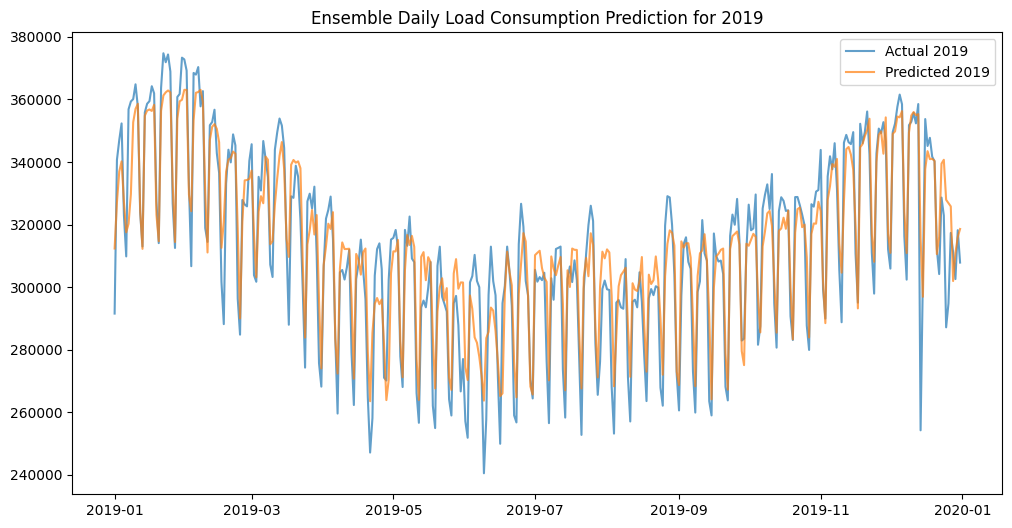

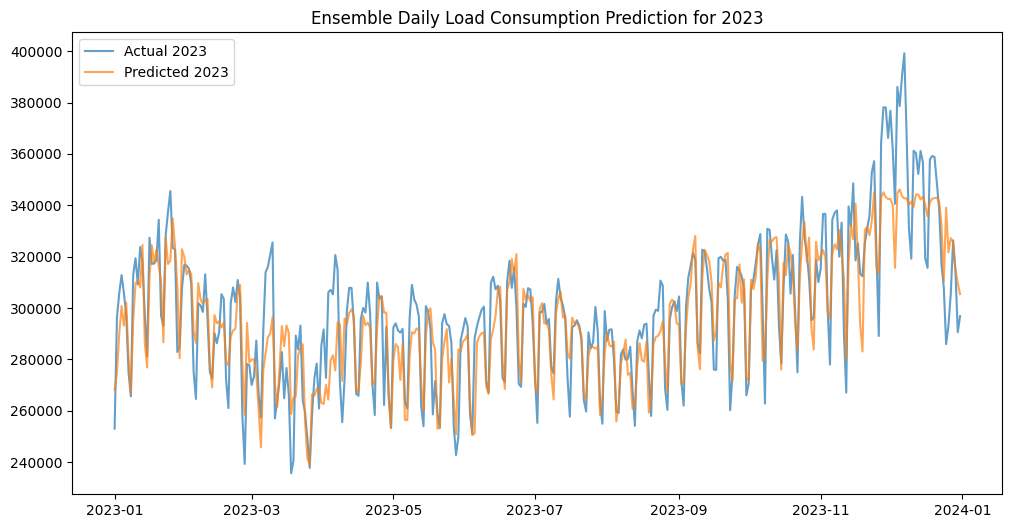

In [25]:
## Stage 3: Testing Performance on 2019 and 2023
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"
X_daily = daily_features
y_daily = daily_data[daily_target]

# Compute feature importance
daily_feature_importance = feature_importance_rfa(X_daily, y_daily)
selected_daily_features = list(daily_feature_importance.index[:5]) + ["Predicted_Monthly_Load"]
X_daily = X_daily[selected_daily_features]

# Define 2019 and 2023 data
X_train_2019 = X_daily.loc["2018-01-01":"2018-12-31"]
y_train_2019 = y_daily.loc["2018-01-01":"2018-12-31"]
X_test_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_2019 = y_daily.loc["2019-01-01":"2019-12-31"]

X_train_2022 = X_daily.loc["2021-01-01":"2021-12-31"]
y_train_2022 = y_daily.loc["2021-01-01":"2021-12-31"]
X_test_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

# Train Ensemble Model on 2018 and Predict 2019
scaler = StandardScaler()
X_train_scaled_2019 = scaler.fit_transform(X_train_2019)
X_test_scaled_2019 = scaler.transform(X_test_2019)

ensemble_model_2019 = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=6))
])
ensemble_model_2019.fit(X_train_scaled_2019, y_train_2019)
y_pred_2019 = ensemble_model_2019.predict(X_test_scaled_2019)

# Train Ensemble Model on 2021 and Predict 2023
X_train_scaled_2022 = scaler.fit_transform(X_train_2022)
X_test_scaled_2023 = scaler.transform(X_test_2023)

ensemble_model_2023 = VotingRegressor([
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5))
])
ensemble_model_2023.fit(X_train_scaled_2022, y_train_2022)
y_pred_2023 = ensemble_model_2023.predict(X_test_scaled_2023)

# Evaluate
print("2019 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2019, y_pred_2019)}, MSE: {mean_squared_error(y_test_2019, y_pred_2019)}, R^2: {r2_score(y_test_2019, y_pred_2019)}, MAPE: {np.mean(np.abs((y_test_2019 - y_pred_2019) / y_test_2019)) * 100}")

print("2023 Ensemble Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_2023, y_pred_2023)}, MSE: {mean_squared_error(y_test_2023, y_pred_2023)}, R^2: {r2_score(y_test_2023, y_pred_2023)}, MAPE: {np.mean(np.abs((y_test_2023 - y_pred_2023) / y_test_2023)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_2019.index, y_test_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Predicted 2019", alpha=0.7)
plt.legend()
plt.title("Ensemble Daily Load Consumption Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_2023.index, y_test_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Predicted 2023", alpha=0.7)
plt.legend()
plt.title("Ensemble Daily Load Consumption Prediction for 2023")
plt.show()


In [26]:
# Single-Stage Model: Train Directly on Full Data
X_train_single = X_daily.loc["2018-01-01":"2021-12-31"]
y_train_single = y_daily.loc["2018-01-01":"2021-12-31"]
X_test_single_2019 = X_daily.loc["2019-01-01":"2019-12-31"]
y_test_single_2019 = y_daily.loc["2019-01-01":"2019-12-31"]
X_test_single_2023 = X_daily.loc["2023-01-01":"2023-12-31"]
y_test_single_2023 = y_daily.loc["2023-01-01":"2023-12-31"]

scaler_single = StandardScaler()
X_train_scaled_single = scaler_single.fit_transform(X_train_single)
X_test_scaled_single_2019 = scaler_single.transform(X_test_single_2019)
X_test_scaled_single_2023 = scaler_single.transform(X_test_single_2023)

# Train Single-Stage Model (XGBoost for better results)
model_single = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5)
model_single.fit(X_train_scaled_single, y_train_single)
y_pred_single_2019 = model_single.predict(X_test_scaled_single_2019)
y_pred_single_2023 = model_single.predict(X_test_scaled_single_2023)

# Evaluate
print("2019 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2019, y_pred_single_2019)}, "
      f"MSE: {mean_squared_error(y_test_single_2019, y_pred_single_2019)}, "
      f"R^2: {r2_score(y_test_single_2019, y_pred_single_2019)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2019 - y_pred_single_2019) / y_test_single_2019)) * 100}")

print("2023 Single-Stage Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_single_2023, y_pred_single_2023)}, "
      f"MSE: {mean_squared_error(y_test_single_2023, y_pred_single_2023)}, "
      f"R^2: {r2_score(y_test_single_2023, y_pred_single_2023)}, "
      f"MAPE: {np.mean(np.abs((y_test_single_2023 - y_pred_single_2023) / y_test_single_2023)) * 100}")


2019 Single-Stage Model Performance:
MAE: 4381.668522260275, MSE: 33884617.38023732, R^2: 0.9614893753696129, MAPE: 1.429462220623784
2023 Single-Stage Model Performance:
MAE: 9798.071806506849, MSE: 182322087.68642205, R^2: 0.7752085608689956, MAPE: 3.2769972972502814


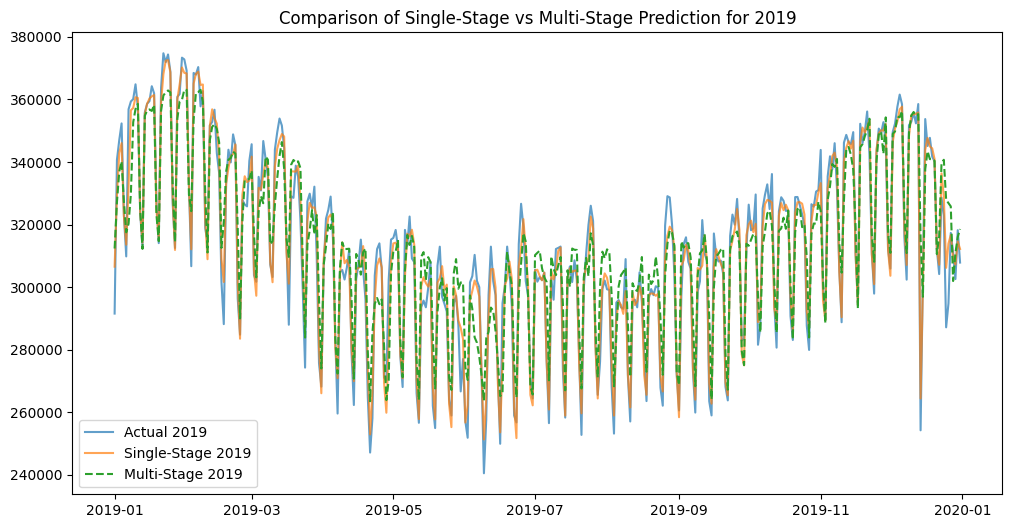

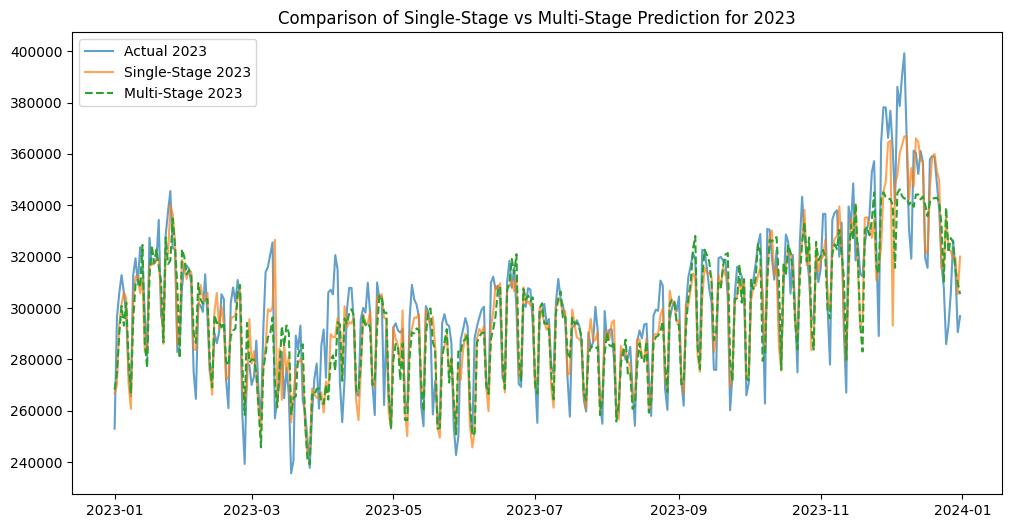

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_test_single_2019.index, y_test_single_2019, label="Actual 2019", alpha=0.7)
plt.plot(y_test_single_2019.index, y_pred_single_2019, label="Single-Stage 2019", alpha=0.7)
plt.plot(y_test_2019.index, y_pred_2019, label="Multi-Stage 2019", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2019")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_single_2023.index, y_test_single_2023, label="Actual 2023", alpha=0.7)
plt.plot(y_test_single_2023.index, y_pred_single_2023, label="Single-Stage 2023", alpha=0.7)
plt.plot(y_test_2023.index, y_pred_2023, label="Multi-Stage 2023", linestyle="dashed")
plt.legend()
plt.title("Comparison of Single-Stage vs Multi-Stage Prediction for 2023")
plt.show()


In [28]:
daily_data.columns

Index(['loadConsumption', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'rolling_mean_7', 'rolling_std_7', 'DailyPrecipitation',
       'MaxHourlyPrecipitation', 'HDMaxPrecipitation', 'DailyMeanTemperature',
       'HourlyMinTemperature', 'HDMinTemperature', 'HourlyMaxTemperature',
       'HDMaxTemperature', 'DailyMeanWindspeed', 'MaxHourlyMeanWindspeed',
       'HDMaxMeanWindspeed', 'MinHourlyMeanWindspeed', 'HDMinMeanWindspeed',
       'Month', 'Year', 'Week', 'WeekKey', 'Predicted_Monthly_Load',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday'],
      dtype='object')

Epoch 1/50
163/163 [==============================] - 14s 51ms/step - loss: 0.4792 - val_loss: 0.4707
Epoch 2/50
163/163 [==============================] - 7s 44ms/step - loss: 0.2569 - val_loss: 0.7294
Epoch 3/50
163/163 [==============================] - 8s 47ms/step - loss: 0.1807 - val_loss: 0.2338
Epoch 4/50
163/163 [==============================] - 7s 43ms/step - loss: 0.1438 - val_loss: 0.2360
Epoch 5/50
163/163 [==============================] - 7s 44ms/step - loss: 0.1305 - val_loss: 0.1948
Epoch 6/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1191 - val_loss: 0.1959
Epoch 7/50
163/163 [==============================] - 8s 46ms/step - loss: 0.1171 - val_loss: 0.1883
Epoch 8/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1075 - val_loss: 0.2165
Epoch 9/50
163/163 [==============================] - 7s 45ms/step - loss: 0.1041 - val_loss: 0.1760
Epoch 10/50
163/163 [==============================] - 7s 43ms/step - loss: 0.0999 - val_l

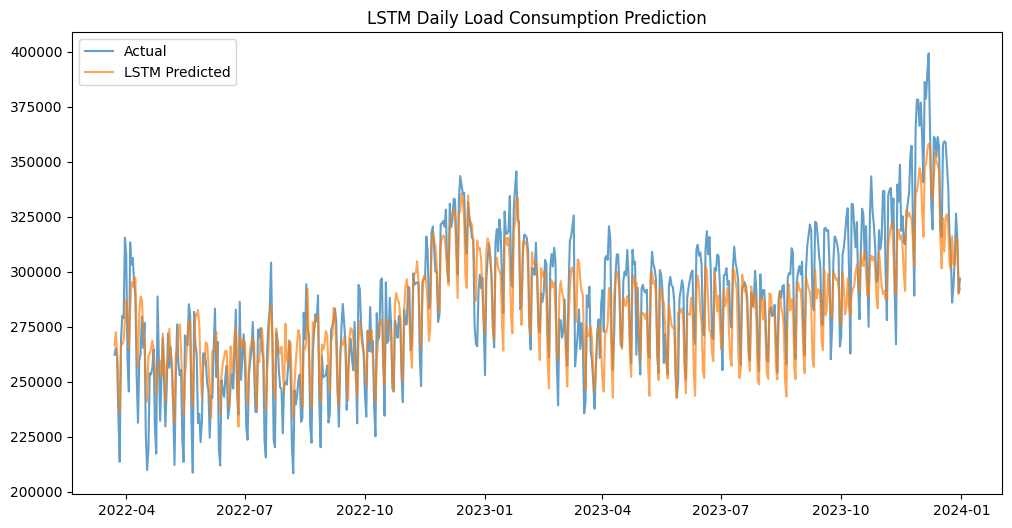

In [29]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = daily_data.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(daily_data[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=daily_data.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back

# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(daily_data.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(daily_data.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()
